1. Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import warnings
import re
from datetime import datetime
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown


#### 1.0 Funciones útiles

In [130]:
def showPie(columna, excluir=["SD"], max=15):
  for substring in excluir:
    columna = columna[~columna.astype(str).str.contains(substring)]
  
  count_values = pd.Series(columna).value_counts()
  count_2 = count_values.copy()
  
  if max > count_values.shape[0]:
    max = count_values.shape[0]
  
  if len(count_values) > max:
      count_values = count_2.iloc[:max]
      count_values['Otros'] = count_2.iloc[max:].sum()
      
  if 'Otros' not in count_values.index:
    count_values['Otros'] = 0
  
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()
 
def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15, pref="", title=""):
  count_values = pd.Series(columna).value_counts()
  count_2 = count_values.copy()
  
  if max > count_values.shape[0]:
    max = count_values.shape[0]
  
  if len(count_values) > max:
      count_values = count_2.iloc[:max]
      count_values['Otros'] = count_2.iloc[max:].sum()
      
  if 'Otros' not in count_values.index:
    count_values['Otros'] = 0
  
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

     
  # Plot pie chart using Plotly Express
  fig = px.pie(datos, values='ocurrencia', names='valor', title=title)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()

def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])

def resumen(data, nombre_tabla="Resumen Tabla"):
    filas, columnas = data.shape
    valores = filas * columnas
    nulos, duplicados =  data.isna().values.sum(), data.duplicated().sum()
    tasa_nulos, tasa_duplicados = nulos / valores, duplicados / valores

    salida = f'''<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>{nombre_tabla}</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> {filas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> {columnas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> {valores} </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> {nulos} </td><td style='text-align: right'> {round(100*tasa_nulos, 2)} % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> {duplicados} </td><td style='text-align: right'> {round(100*tasa_duplicados, 2)} %</td><tr/>
    </tbody>
    </table>'''

    display(Markdown(salida))

def ver_nulos_x_fila(data):
  ax = sns.barplot(x=nulos_filas(data).cant_col_nulas, y=nulos_filas(data).cantidad)
  for i in ax.containers:
      ax.bar_label(i,)
  plt.title("cantidad nulos x fila")
  plt.show()

def ver_nulos_x_columna(data):
  nulos_columnas = data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False)
  # ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
  if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
    for i in ax.containers:
      ax.bar_label(i,)

## 1.1 Extracción, Transformación y Carga de Datos (ETL)

### 1.1.1 Extracción

In [3]:

# Datos Homicidios Hechos
data_hm = pd.read_excel('data/homicidios.xlsx', sheet_name='HECHOS')

# Datos Homicidios Victimas
data_vm = pd.read_excel('data/homicidios.xlsx', sheet_name='VICTIMAS')
# Datos Lesiones Hechos
# data_hl = pd.read_excel('data/lesiones.xlsx', sheet_name='HECHOS')
data_hl = pd.read_csv('data/generated/data_hl.csv')
# Datos Lesiones Victimas
# data_vl = pd.read_excel('data/lesiones.xlsx', sheet_name='VICTIMAS')
data_vl = pd.read_csv('data/generated/data_vl.csv')

# https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_resultados_provisionales.pdf Página 8
data_pob_comunas = pd.read_excel('data/cnphv2022_resultados_provisionales.xlsx', sheet_name='Table 2').query("Comuna != 'Total'").iloc[:,[3]]

# Barrios
df_barrios = pd.read_excel('data/barrios.xlsx')
# Comunas
df_comunas = pd.read_excel('data/comunas.xlsx')

### 1.1.2 Transformación

### 1.1.2.1 Dataset Homicidios

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [4]:
resumen(data_hm)

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Resumen Tabla</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 696 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 21 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 14616 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 747 </td><td style='text-align: right'> 5.11 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 0 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

#### 1.1.2.1.1 Análisis de Nulos

##### a. Por filas

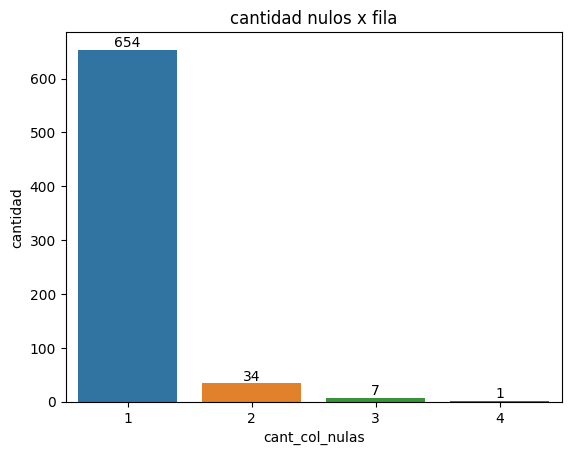

In [5]:
ver_nulos_x_fila(data_hm)

Significa que hay 654 filas que tienen una columna nula, 34 filas con 2 columnas nulas. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

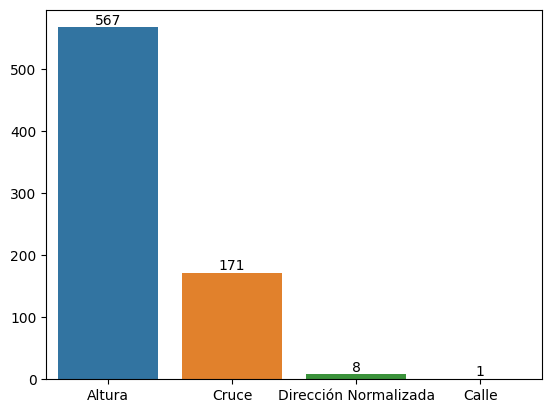

In [6]:
ver_nulos_x_columna(data_hm)

In [7]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hm.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hm.isna().T.sum()>0)}")

Cantidad filas: 696
Cantidad filas al menos un nulo: 696


Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

In [8]:
# La columna altura se llena con ESQ cuando es esquina
# data_hm.Altura = data_hm.Altura.fillna('ESQ')
data_hm.fillna({'Altura': "ESQ"}, inplace = True)

# Se limpia el valor altura cuando lo toma como decimal
data_hm.Altura = data_hm.Altura.apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

In [9]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hm.fillna({'Cruce': "N_A"}, inplace = True)

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

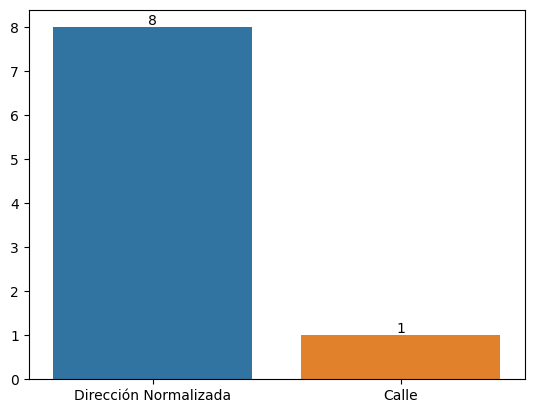

In [10]:
ver_nulos_x_columna(data_hm)

Columna ```Dirección Normalizada```

In [11]:
data_hm[data_hm.isna().loc[:, 'Dirección Normalizada']].head(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,ESQ,N_A,NaN,13,Point (. .),.,.,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,ESQ,N_A,NaN,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,N_A,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Rellenamos la información faltante en la columna ```Dirección Normalizada``` con los valores de ```LUGAR_DEL_HECHO```

In [12]:
nulos = [idx for idx, _ in enumerate(data_hm['Dirección Normalizada'].isna())]
for i in nulos:
    data_hm.loc[i, 'Dirección Normalizada'] = data_hm.loc[i, 'LUGAR_DEL_HECHO']

Columna ```Calle```

In [13]:
data_hm[data_hm.isna().loc[:, 'Calle']].T

,119
ID,2016-0151
N_VICTIMAS,1
FECHA,2016-11-18 00:00:00
AAAA,2016
MM,11
DD,18
HORA,20:35:00
HH,20
LUGAR_DEL_HECHO,SD
TIPO_DE_CALLE,CALLE


No tenemos información suficiente en el registro ```2016-0151```. No tenemos información geográfica, estos registros podemos diferenciarlos posteriormente para saber en qué análisis los incluimos y en cuáles no.

In [14]:
data_hm[data_hm.loc[:, 'Calle'].isna()].fillna({'Calle': 'SD'}, inplace=True)

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

Columnas <code>"pos x"</code> y <code>"pos y"</code>

Marcamos las filas que no tienen valores geográficos.

In [15]:
data_hm['data_geo'] = True

limpiar_coord = lambda x: 0 if x == '.' else float(x)
data_hm['pos x'] = data_hm['pos x'].apply(limpiar_coord)
data_hm['pos y'] = data_hm['pos y'].apply(limpiar_coord)

for i in data_hm.index:
    if data_hm.loc[i, 'pos x'] == 0:
        data_hm.loc[i, 'data_geo'] = False
    if data_hm.loc[i, 'pos y'] == 0:
        data_hm.loc[i, 'data_geo'] = False

data_hm['data_geo'].value_counts()        

data_geo
True     684
False     12
Name: count, dtype: int64

Columna <code>COMUNA</code>

In [16]:
data_hm.loc[:, 'COMUNA'] = data_hm.loc[:, 'COMUNA'].astype(str);

In [17]:
data_hm.query("COMUNA == '0'")

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,N_A,SD,0,Point (. .),0.0,0.0,PEATON-SD,PEATON,SD,False
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,N_A,AUTOPISTA 25 DE MAYO,0,Point (. .),0.0,0.0,SD-SD,SD,SD,False


Vemos que la marca <code>data_geo</code> está en <code>Falso</code> por lo tanto, estos registros que no tienen <code>Comuna</code> definida, no se registrarán para análisis geográficos.

In [18]:
data_hm[data_hm.loc[:, 'Dirección Normalizada'] == 'SD']

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,N_A,SD,0,Point (. .),0.0,0.0,PEATON-SD,PEATON,SD,False


Mismo caso que el anterior, para excluir de los análisis geográficos.

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [19]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

Columna <code>Hora</code>

In [20]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo
518,2019-0103,1,2019-12-18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,GRIVEO,"PAZ, GRAL. AV. Y GRIVEO",11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,True


In [21]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')
data_hm["HORA"] = data_hm["HORA"].astype(str)
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)
data_hm['HORA'] = data_hm['HORA'].astype(str)

Creación de la columna <code>FECHA_HORA</code> a partir de las columnas de fecha y hora.

In [22]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))
data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)



In [23]:
data_hm.query("Calle.isna()")
data_hm.fillna({'Calle': 'SD'}, inplace=True)

In [24]:
data_hm['FECHA_HORA']

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 696, dtype: datetime64[ns]

In [25]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [26]:
data_hm[data_hm['data_geo']]['pos x'].mean()

-58.441545233561044

In [27]:
data_hm[data_hm['data_geo']]['pos y'].mean()

-34.61963157034327

In [28]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'N_A'

In [29]:
data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo,FECHA_HORA,ES_CRUCE
ID,,,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.",AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,AV GRAL PAZ Y AV DE LOS CORRALES,9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,N_A,AV ENTRE RIOS 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.",AV LARRAZABAL Y GRAL VILLEGAS CONRADO,8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.",AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,AV. RIESTRA Y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,AU DELLEPIANE Y LACARRA,9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,AV. GAONA Y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


In [30]:
# data_hm = data_hm.drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [31]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

In [32]:
data_hm;

In [33]:
df_comunas['barrios'] = df_comunas.BARRIOS.apply(lambda x: x.split(' - '))

In [34]:

df_comunas.rename({'COMUNAS':'comuna'}, axis=1, inplace=True)
df_comunas.index = df_comunas['comuna']
df_comunas.drop(['ID', 'OBJETO', 'BARRIOS'], axis=1, inplace=True, errors='ignore')
df_comunas.rename({'comuna':'nombre_comuna', 'PERIMETRO':'perimetro', 'AREA':'area'}, axis=1, inplace=True)


Obtenemos la información de la población de comunas y actualizamos el frame <code>df_comunas</code>

In [35]:
data_pob_comunas.reset_index(inplace=True)
data_pob_comunas.rename({'index':'comuna', 'Total de población':'poblacion'}, axis=1, inplace=True)
data_pob_comunas.index = data_pob_comunas['comuna']
data_pob_comunas.rename({'comuna': 'nombre_comuna'}, axis=1, inplace=True)

df_comunas_pob = pd.merge(df_comunas, data_pob_comunas['poblacion'], left_index=True, right_index=True)
# df_comunas.rename({'nombre_comuna_x':'nombre_comuna','poblacion_x':'poblacion'}, axis=1, inplace=True)

df_comunas_pob.to_csv('data/generated/data_comunas_pob.csv')

In [36]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

### 1.1.2.2 Dataset Lesiones

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [37]:
import pandas as pd
import numpy as np

columnas_usar = ['id', 'n_victimas', 'fecha', 'hora',
       'direccion_normalizada', 'comuna', 'tipo_calle',
       'otra_direccion', 'calle', 'altura', 'cruce', 
       'longitud', 'latutid', 'victima', 'acusado', 'participantes', 'moto',
       'auto', 'transporte_publico', 'camion', 'ciclista', 'gravedad']

data_hl = pd.read_csv('data/generated/data_hl.csv', usecols=columnas_usar, index_col='id')

data_hl.rename({'latutid': 'latitud'}, axis=1, inplace=True)

In [38]:
data_hl.loc[:,'gravedad'] = data_hl.loc[:,'gravedad'].apply(lambda st: str(st).upper())
data_hl.loc[:,'gravedad'].value_counts()

data_hl.loc[:,'gravedad']=data_hl.loc[:,'gravedad'].replace('SD', 'NO_GRAVE');

data_hl.loc[:, 'gravedad'].value_counts()

# data_hl.loc[:, 'grave'] = data_hl.loc[:, 'grave'].apply(lambda st: False if pd.isna(st) else True)

gravedad
NO_GRAVE    23139
GRAVE         643
FATAL           3
Name: count, dtype: int64

Limpieza de nulos geográficos

In [39]:
# data_hl.loc[:,'direccion_normalizada'] = data_hl.loc[:,'direccion_normalizada'].replace('SD', np.nan)

pd.set_option('future.no_silent_downcasting', True)
data_hl = data_hl.replace('SD', np.nan)

len(data_hl.query("direccion_normalizada.isna()"))
data_hl.fillna({'cruce': ''}, inplace=True)

data_hl['altura'] = data_hl['altura'].apply(lambda x: int(x) if not pd.isna(x) else 0)

mask = data_hl['direccion_normalizada'].isna()
data_hl.loc[mask, 'direccion_normalizada'] = data_hl.loc[mask, 'otra_direccion']
data_hl['direccion_normalizada'] = data_hl['direccion_normalizada'].str.extract(r'(.+?)(?=, Barrio:|$)', expand=False)

indices = data_hl.query("direccion_normalizada.isna() and calle.notna()")[['direccion_normalizada', 'otra_direccion', 'comuna', 'calle', 'altura', 'cruce']].index
data_hl.altura = data_hl.altura.astype(str)


for i in list(indices):
    if not data_hl.loc[i, 'altura'] in [0, 'nan']:
        data_hl.loc[i, 'direccion_normalizada'] = data_hl.loc[i, 'calle'] + ' ' + data_hl.loc[i, 'altura']
    else:
        data_hl.loc[i, 'direccion_normalizada'] = data_hl.loc[i, 'calle'] + ' y ' + data_hl.loc[i, 'cruce']
        
data_hl['data_geo'] = ~ (data_hl['direccion_normalizada'].isna() & 
                        data_hl['otra_direccion'].isna() & 
                        data_hl['latitud'].isna() & 
                        data_hl['cruce'].notna())

for i in data_hl.query("data_geo and longitud.isna()").index:
    data_hl.loc[i, 'data_geo'] = False;



In [40]:
resumen(data_hl, "Lesiones")

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Lesiones</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 23785 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 22 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 523270 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 132992 </td><td style='text-align: right'> 25.42 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 22 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

In [41]:
data_hl.drop_duplicates(inplace=True)

#### 1.1.2.2.1 Análisis de Nulos

##### a. Por filas

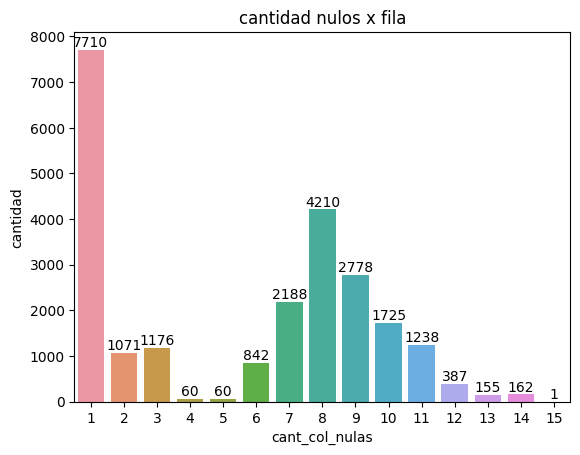

In [42]:
ver_nulos_x_fila(data_hl)

Significa que hay 287 filas que tienen una columna nula, 7437 filas con 2 columnas nula. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

Separamos un subset para trabajar después

In [43]:
try:
    data_adicional = data_hl.loc[:,['moto', 'auto', 'transporte_publico', 'camion', 'ciclista']]

    data_adicional.loc[:, 'involucrado'] = data_adicional.eq('x').idxmax(axis=1).str.upper()
    data_adicional.loc[:, 'involucrado'] = data_adicional['involucrado'].apply(lambda x: 'SD' if x == 'ID' else x)
except:
    print("posiblemente operación ya realizada!!!")

In [44]:
data_hl = data_hl[data_hl.columns[~data_hl.columns.isin(data_adicional.columns)]]
# data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [45]:
len(data_adicional)

23763

Dividimos el dataset en 2 para trabajar mejor con los gráficos

In [46]:
# data_1 = data_hl.iloc[:, :int(data_hl.shape[1]/2)]

# data_2 = data_hl.iloc[:,int(data_hl.shape[1]/2)+1:]

In [47]:
data_hl.columns

Index(['n_victimas', 'fecha', 'hora', 'direccion_normalizada', 'comuna',
       'tipo_calle', 'otra_direccion', 'calle', 'altura', 'cruce', 'longitud',
       'latitud', 'victima', 'acusado', 'participantes', 'gravedad',
       'data_geo'],
      dtype='object')

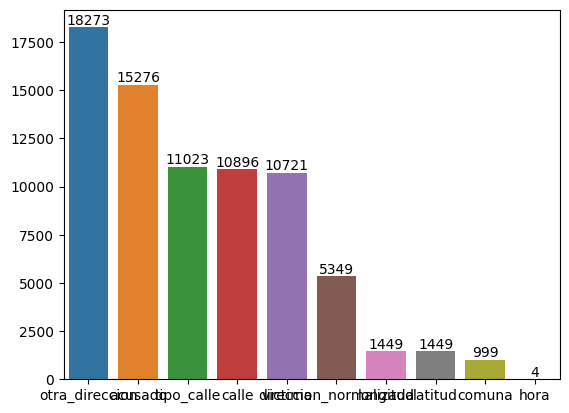

In [48]:
ver_nulos_x_columna(data_hl)

In [49]:
# nulos_columnas = data_2.isna().sum()[data_2.isna().sum() > 0].sort_values(ascending=False)
# ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
# for i in ax.containers:
#     ax.bar_label(i,)

In [50]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hl.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hl.isna().T.sum()>0)}")

Cantidad filas: 23763
Cantidad filas al menos un nulo: 23763


Debido a la gran cantidad de nulos, y viendo un panorama del dataset, vamos a hacer un recorte de las columnas más útiles a criterio del analista

In [51]:
# columnas_conservar = ['id', 'n_victimas', 'fecha', 'hora','direccion_normalizada', 'comuna','tipo_calle','otra_direccion','calle','altura','cruce','longitud', 'latutid', 'victima', 'gravedad']

In [52]:
# data_hl = data_hl[columnas_conservar]

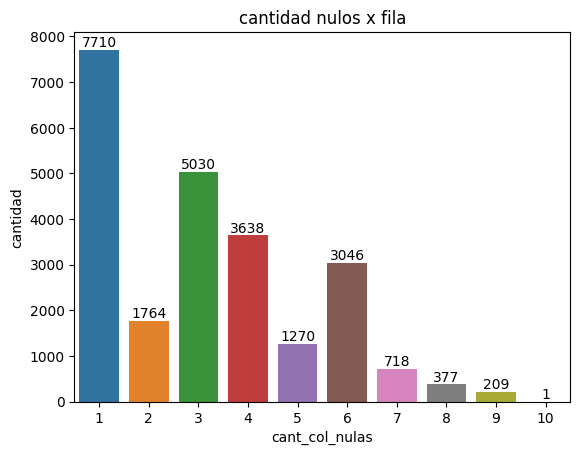

In [53]:
ver_nulos_x_fila(data_hl)

In [54]:
data_hl = pd.merge(data_hl,data_adicional, on='id')

In [55]:
# data_hl.dropna(subset=['comuna'], inplace=True)

data_hl.drop(['transporte_publico',	'moto',  'auto', 'camion',	'ciclista'], axis=1, inplace=True, errors='ignore')

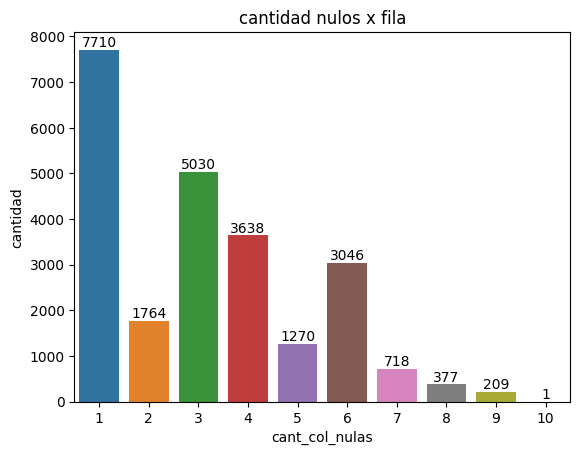

In [56]:
# ax = sns.barplot(x=nulos_filas(data_hl2).cant_col_nulas, y=nulos_filas(data_hl2).cantidad)
# for i in ax.containers:
#     ax.bar_label(i,)
# plt.title("cantidad nulos x fila")
# plt.show()

ver_nulos_x_fila(data_hl)

Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

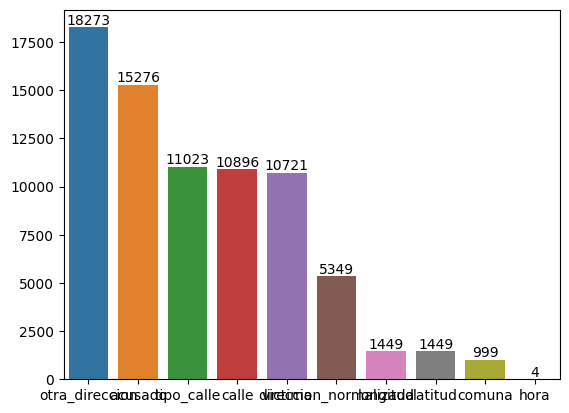

In [57]:
ver_nulos_x_columna(data_hl)

Columna <code>otra_direccion</code>

In [58]:
longitude= -58.421738
latitude = -34.581182
zoom_level = 15

url = f'https://www.google.com/maps/@{latitude},{longitude},{zoom_level}z?hl=es&markers={latitude},{longitude}'
url

'https://www.google.com/maps/@-34.581182,-58.421738,15z?hl=es&markers=-34.581182,-58.421738'

In [59]:
data_hl.query("otra_direccion.isna() and data_geo").head(3)

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado
id,,,,,,,,,,,,,,,,,,
LC-2019-0405413,1,2019-07-01 00:00:00,22:30:00,NaN,14,NaN,NaN,NaN,0,,-58.421738,-34.581182,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA
LC-2019-0406180,1,2019-07-01 00:00:00,10:55:00,NaN,2,NaN,NaN,NaN,0,,-58.409629,-34.595662,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA
LC-2019-0408076,1,2019-07-01 00:00:00,20:40:00,NaN,12,NaN,NaN,NaN,0,,-58.485879,-34.543475,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,MOTO


Columna <code>Gravedad</code>

In [60]:
data_hl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23763 entries, LC-2019-0000179 to LC-2020-0244615
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   n_victimas             23763 non-null  int64 
 1   fecha                  23763 non-null  object
 2   hora                   23759 non-null  object
 3   direccion_normalizada  18414 non-null  object
 4   comuna                 22764 non-null  object
 5   tipo_calle             12740 non-null  object
 6   otra_direccion         5490 non-null   object
 7   calle                  12867 non-null  object
 8   altura                 23763 non-null  object
 9   cruce                  23763 non-null  object
 10  longitud               22314 non-null  object
 11  latitud                22314 non-null  object
 12  victima                13042 non-null  object
 13  acusado                8487 non-null   object
 14  participantes          23763 non-null  object
 15  

In [61]:
data_hl.cruce

id
LC-2019-0000179           
LC-2019-0000053           
LC-2019-0000063           
LC-2019-0000079           
LC-2019-0000082           
                    ...   
LC-2021-0652849    GUAMINI
LC-2021-0652865           
LC-2021-0652907           
LC-2021-0652921     MORENO
LC-2020-0244615           
Name: cruce, Length: 23763, dtype: object

In [62]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hl.cruce = data_hl.cruce.fillna('NA')

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

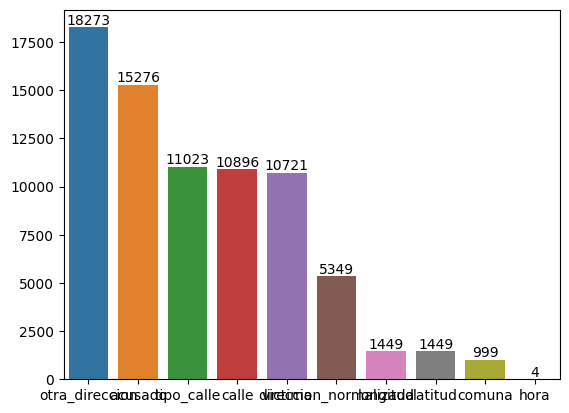

In [63]:
nulos_columnas = data_hl.isna().sum()[data_hl.isna().sum() > 0].sort_values(ascending=False)

if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [64]:
data_hl.query('otra_direccion.notna() and calle.isna()').loc['LC-2019-0000179'].otra_direccion

'Obligado Rafael, Av.Costanera 3300, Barrio: Palermo  , jurisdicción comisaria:  Vecinal 14C'

In [65]:
pattern = r"Barrio:\s*([^,]+)"
data_hl['barrio'] = data_hl['otra_direccion'].str.extract(pattern, expand=False)

In [66]:
data_hl['barrio'].value_counts()

barrio
Palermo                                      381
Flores                                       267
Balvanera                                    256
Caballito                                    230
Recoleta                                     214
                                            ... 
Boedo Vía Pública                              1
No Especificada Villa 31                       1
Retiro MANZANA 14                              1
Belgrano PARADA DEL 68 DEL METROBUS            1
Constitucion INTERIOR COLECTIVO LINEA 23       1
Name: count, Length: 171, dtype: int64

In [67]:
data_hl.drop('otra_direccion', axis=1, inplace=True)

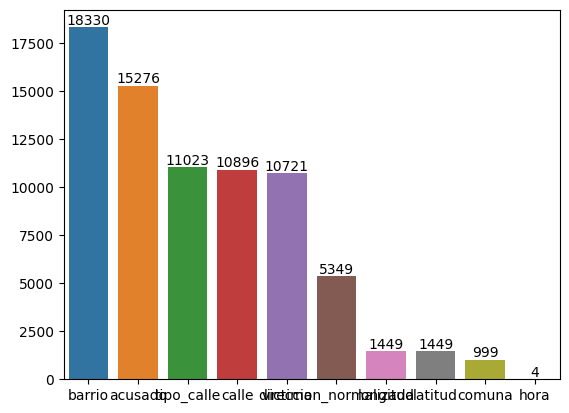

In [68]:
ver_nulos_x_columna(data_hl)

In [69]:
data_hl.loc[:,'direccion_normalizada'].fillna("SD", inplace=True)

Columna ```Dirección Normalizada```

In [70]:
data_hl[data_hl.isna().loc[:, 'direccion_normalizada']].query('data_geo')

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio
id,,,,,,,,,,,,,,,,,,


In [71]:
data_hl.fillna({'direccion_normalizada':'SD'}, inplace=True)

Columna ```Calle```

In [72]:
data_hl.query('calle.isna() and data_geo == True')

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio
id,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo
LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,"Autopista Presidente Héctor J. Cámpora y Roca,...",8,NaN,NaN,0,,-58.44351,-34.669125,AUTO,NaN,AUTO-SD,NO_GRAVE,True,AUTO,Villa Soldati
LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano
LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan
LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0630499,1,2021-12-18 00:00:00,16:40:00,Corrientes Av. y Uriburu Jose E.,3,AVENIDA,NaN,0,,-58.398221919489,-34.604579570175,MOTO,NaN,MOTO-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0641694,1,2021-12-24 00:00:00,19:40:00,"Autopista 25 de Mayo km. 5,0 sentido CABA",NaN,NaN,NaN,0,,-58.4024529002351,-34.5704677450857,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0643354,1,2021-12-24 00:00:00,09:00:00,"Alvear, Marcelo T. De y Uriburu Jose E., Pres.",2,NaN,NaN,0,,-58.398875,-34.597048,NaN,MOTO,SD-MOTO,NO_GRAVE,True,MOTO,NaN


In [73]:
mask_auto = data_hl[data_hl.loc[:,'direccion_normalizada'].apply(lambda st: st.startswith('Autopista '))].index

data_hl.loc[mask_auto, 'tipo_calle'] = 'AUTOPISTA'

data_hl.loc[mask_auto, 'direccion_normalizada'] = data_hl.loc[mask_auto, 'direccion_normalizada'][10:]

In [74]:
def limpiar_auto(st):
    try:
        if st.startswith('Autopista '):
            return st[10:]
    except:
        return st

In [75]:
data_hl.loc[:,'direccion_normalizada'].apply(limpiar_auto)

id
LC-2019-0000179    None
LC-2019-0000053     NaN
LC-2019-0000063    None
LC-2019-0000079    None
LC-2019-0000082    None
                   ... 
LC-2021-0652849    None
LC-2021-0652865    None
LC-2021-0652907    None
LC-2021-0652921    None
LC-2020-0244615    None
Name: direccion_normalizada, Length: 23763, dtype: object

In [76]:
data_hl.loc[:,'direccion_normalizada']

id
LC-2019-0000179           Obligado Rafael, Av.Costanera 3300
LC-2019-0000053                                          NaN
LC-2019-0000063               Barros Pazos, Jose y Larraya 0
LC-2019-0000079      Torres Y Tenorio, Pres. y Riestra Av. 0
LC-2019-0000082    Corrientes Av. y Uriburu Jose E., Pres. 0
                                     ...                    
LC-2021-0652849         ALBERDI, JUAN BAUTISTA AV. y GUAMINI
LC-2021-0652865              ALBERDI, JUAN BAUTISTA AV. 4436
LC-2021-0652907    Barrio Padre Carlos Mugica (Villa 31 bis)
LC-2021-0652921                      LINIERS VIRREY y MORENO
LC-2020-0244615                                           SD
Name: direccion_normalizada, Length: 23763, dtype: object

In [77]:
data_hl.query("data_geo and calle.isna() and tipo_calle.isna()")

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio
id,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo
LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano
LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan
LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera
LC-2019-0000136,2,2019-01-01 00:00:00,08:05:00,Cordoba Av. y Humboldt 0,15,NaN,NaN,0,,-58.439392,-34.588108,MOTO,NaN,MOTO-SD,NO_GRAVE,True,MOTO,Chacarita
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0628675,4,2021-12-17 00:00:00,13:00:00,SD,1,NaN,NaN,0,,-58.38145,-34.606663,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0629150,1,2021-12-17 00:00:00,16:00:00,SD,1,NaN,NaN,0,,-58.381749,-34.601891,TRANSPORTE PUBLICO,TRANSPORTE PUBLICO,TRANSPORTE PUBLICO-TRANSPORTE PUBLICO,NO_GRAVE,True,TRANSPORTE_PUBLICO,NaN
LC-2021-0643354,1,2021-12-24 00:00:00,09:00:00,"Alvear, Marcelo T. De y Uriburu Jose E., Pres.",2,NaN,NaN,0,,-58.398875,-34.597048,NaN,MOTO,SD-MOTO,NO_GRAVE,True,MOTO,NaN


In [78]:
data_hl[data_hl['direccion_normalizada'].isna()].loc[:, 'direccion_normalizada'] = 'SD'

In [79]:
data_hl['direccion_normalizada'].fillna("SD", inplace=True)

In [80]:
mask = data_hl['direccion_normalizada'].str.startswith('Rafael Obligado')
filtered_data = data_hl[mask]

In [81]:
data_hl['data_geo'].value_counts()

data_geo
True     22314
False     1449
Name: count, dtype: int64

In [82]:
# data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
# data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)
# data_hm[data_hm['pos x'].isna()]
# data_hm.query("PARTICIPANTES == 'SD-SD'")
data_hl.query("comuna == 0")
# data_hm.COMUNA.isnull().sum()

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio
id,,,,,,,,,,,,,,,,,,


In [83]:
contar_nulos(data_hl)

n_victimas                   0
fecha                        0
hora                         4
direccion_normalizada        0
comuna                     999
tipo_calle               10994
calle                    10896
altura                       0
cruce                        0
longitud                  1449
latitud                   1449
victima                  10721
acusado                  15276
participantes                0
gravedad                     0
data_geo                     0
involucrado                  0
barrio                   18330
dtype: int64

Normalización <code>Fecha</code> y <code>Hora</code>

In [84]:
# data_hl["hora"] = data_hl["hora"].str.lower().replace('sd', '00:00:00')
# data_hl["hora"] = data_hl["hora"].astype(str)
# data_hl['hora'] = data_hl['hora'].apply(lambda x: x[11:] if len(x) > 8 else x)
# data_hl['hora'] = data_hl['hora'].astype(str)

In [85]:
data_hl['fecha'] = pd.to_datetime(data_hl['fecha'], format='mixed')

In [86]:
data_hl.fillna({'hora': '00:00:00'}, inplace=True)
data_hl.loc[:, 'hora']=data_hl.loc[:, 'hora'].str.lower().replace('sd')
data_hl

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio
id,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo
LC-2019-0000053,1,2019-01-01,01:55:00,SD,8,AUTOPISTA,NaN,0,,-58.44351,-34.669125,AUTO,NaN,AUTO-SD,NO_GRAVE,True,AUTO,Villa Soldati
LC-2019-0000063,1,2019-01-01,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano
LC-2019-0000079,1,2019-01-01,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan
LC-2019-0000082,4,2019-01-01,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0652849,1,2021-12-31,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,"ALBERDI, JUAN BAUTISTA AV.",0,GUAMINI,-58.513477158887,-34.659713573880,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0652865,2,2021-12-31,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,"ALBERDI, JUAN BAUTISTA AV.",4436,,-58.488326609395,-34.641753304864,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0652907,1,2021-12-31,20:00:00,Barrio Padre Carlos Mugica (Villa 31 bis),1,NaN,NaN,0,,-58.382894,-34.583083,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN


In [87]:
for i in  data_hl['hora'].index:
    try:
        data_hl.loc[i, 'hora'] = pd.to_datetime(data_hl.loc[i, 'hora'], format='mixed')
    except:
        print(data_hl.loc[i, 'hora'])
        

In [88]:
import re

pattern = r'[:\s;-]'

data_hl['fecha_hora'] = (data_hl['fecha'].astype(str) + ' ' + data_hl['hora'].astype(str)).apply(lambda x: re.split(pattern, x))
data_hl['fecha_hora'] = data_hl['fecha_hora'].apply(lambda x: list(map(int, x)))

def to_date(t):
    t2 = [t[0],t[1],t[2],t[6],t[7],t[8]]
    return datetime(* t2)

data_hl['fecha_hora'] = data_hl['fecha_hora'].apply(to_date)
data_hl

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio,fecha_hora
id,,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01,2024-04-17 09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo,2019-01-01 09:00:00
LC-2019-0000053,1,2019-01-01,2024-04-17 01:55:00,SD,8,AUTOPISTA,NaN,0,,-58.44351,-34.669125,AUTO,NaN,AUTO-SD,NO_GRAVE,True,AUTO,Villa Soldati,2019-01-01 01:55:00
LC-2019-0000063,1,2019-01-01,2024-04-17 02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano,2019-01-01 02:00:00
LC-2019-0000079,1,2019-01-01,2024-04-17 02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan,2019-01-01 02:30:00
LC-2019-0000082,4,2019-01-01,2024-04-17 04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera,2019-01-01 04:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0652849,1,2021-12-31,2024-04-17 19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,"ALBERDI, JUAN BAUTISTA AV.",0,GUAMINI,-58.513477158887,-34.659713573880,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN,2021-12-31 19:30:00
LC-2021-0652865,2,2021-12-31,2024-04-17 19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,"ALBERDI, JUAN BAUTISTA AV.",4436,,-58.488326609395,-34.641753304864,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN,2021-12-31 19:40:00
LC-2021-0652907,1,2021-12-31,2024-04-17 20:00:00,Barrio Padre Carlos Mugica (Villa 31 bis),1,NaN,NaN,0,,-58.382894,-34.583083,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN,2021-12-31 20:00:00


In [89]:
pd.DataFrame(data_hl['hora'].unique()).to_csv('horas_unicas.csv')

In [90]:
data_hl.rename({'Barrio': 'barrio'}, axis=1, inplace=True)

Una vez limpia la fecha y la hora, podemos terminar con las columnas faltantes, para luego compatibilizar los 2 datasets

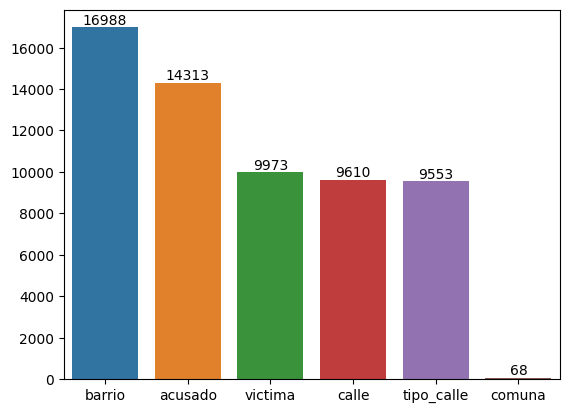

In [91]:
ver_nulos_x_columna(data_hl.query('data_geo'))

In [92]:
# En su momento cambiamos los 'SD' por nulos, para ayudar la verificacion, una vez que ya se trabajaron los nulos, podemos volver a la etiqueta ya mencionada
data_hl.fillna({'barrio': 'SD', 'acusado': 'SD', 'victima':'SD', 'calle':'SD', 'tipo_calle':'SD', 'comuna':'SD'}, inplace=True)

In [93]:
data_hl.columns, data_hm.columns

(Index(['n_victimas', 'fecha', 'hora', 'direccion_normalizada', 'comuna',
        'tipo_calle', 'calle', 'altura', 'cruce', 'longitud', 'latitud',
        'victima', 'acusado', 'participantes', 'gravedad', 'data_geo',
        'involucrado', 'barrio', 'fecha_hora'],
       dtype='object'),
 Index(['id', 'n_victimas', 'fecha', 'hora', 'lugar_del_hecho', 'tipo_de_calle',
        'calle', 'altura', 'cruce', 'dirección_normalizada', 'comuna', 'pos_x',
        'pos_y', 'participantes', 'victima', 'acusado', 'data_geo',
        'fecha_hora', 'es_cruce'],
       dtype='object'))

Comenzamos a compatibilizar

In [94]:
data_hl.drop(['fecha', 'hora'], axis=1, inplace=True)

In [95]:
data_hl['es_cruce'] = data_hl.cruce != ''

In [96]:
data_hl['info_cruce'] = data_hl['calle'] != 'SD'
data_hm['info_cruce'] = data_hm['calle'] != 'SD'

In [97]:
data_hm.fillna({'cruce': 'NA'}, inplace=True)

In [98]:
data_hl.query('cruce.isna()')

,n_victimas,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,barrio,fecha_hora,es_cruce,info_cruce
id,,,,,,,,,,,,,,,,,,,


In [99]:
data_hl.query('info_cruce')['cruce'] = data_hl.query('info_cruce')['cruce'].replace('', 'NA')

In [100]:
data_hm.rename({'pos_x': 'longitud', 'pos_y': 'latitud'}, axis=1, inplace=True)

In [101]:
data_hm['gravedad'] = 'FATAL'
data_hm['involucrado'] = 'SD'
data_hm['barrio'] = 'SD'

In [102]:
data_hl[(data_hl['info_cruce'])&(data_hl['cruce']=='')]['cruce'] = 'SD'

In [103]:
data_hl[(~data_hl['info_cruce'])&(data_hl['cruce']=='')]['cruce']= 'SD'
data_hl[data_hl["cruce"] == ""]['cruce'] ='SD'
data_hl["altura"] = data_hl["altura"].astype(int)
data_hl[data_hl["altura"] > 0]['cruce'] = 'N_A'

In [104]:
def altura_nro(st):
    if st == 'ESQ':
        return False
    if int(st) > 0:
        return True
    return False

data_hl[data_hl['altura'].apply(altura_nro)]['cruce'] = 'N_A'

In [105]:
data_hl['longitud'] = data_hl['longitud'].astype('float')
data_hl['latitud'] = data_hl['latitud'].astype('float')

In [106]:

min = data_hl['longitud'].min()#/1e+08
factor = 1e+08
print(min)
indice = data_hl.query(f'longitud == {min}').index 
data_hl.loc[indice, 'longitud'] /= factor
data_hl.loc[indice, 'latitud'] /= factor


-5829963273.0


In [107]:
data_hl = data_hl[['n_victimas', 'tipo_calle', 'calle', 'altura', 'cruce',
        'direccion_normalizada', 'comuna', 'longitud', 'latitud',
        'participantes', 'victima', 'acusado', 'data_geo', 'fecha_hora',
        'es_cruce', 'info_cruce', 'gravedad', 'involucrado', 'barrio']]

In [108]:
data_hm.rename({'tipo_de_calle':'tipo_calle', 'dirección_normalizada':'direccion_normalizada'}, axis=1,inplace=True)

In [109]:
conjunto = pd.concat([data_hm, data_hl])

In [110]:
conjunto['cruce'] = conjunto['cruce'].astype(str)

In [111]:
conjunto[conjunto['altura'].apply(altura_nro)]['cruce'] = 'N_A'

In [112]:
conjunto.fillna({'longitud':conjunto.longitud.mean(),'latitud':conjunto.latitud.mean()}, inplace=True)

In [113]:
conjunto.reset_index(inplace=True)

In [114]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get database connection details from environment variables
db_username = os.getenv("DB_USERNAME")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_database = os.getenv("DB_DATABASE")

# Define the connection URL
conn_url = f"mysql+pymysql://{db_username}:{db_password}@{db_host}:{db_port}/{db_database}"

# Create a SQLAlchemy engine
engine = create_engine(conn_url)
table_name = "conjunto"

# Now you can use the engine to interact with your database
conjunto.to_sql(name=table_name, con=engine, if_exists='replace', index=True)

24459

In [115]:
conjunto.to_csv('data/generated/conjunto.csv', quoting=csv.QUOTE_ALL)

Ya generados los datasets necesarios podemos proceder al EDA.

# 2. EDA

In [131]:
showPiePx(conjunto.query('data_geo')['gravedad'])

Vemos que el 95% de los accidentes no son graves, siquiera, sólo el 3% es fatal y el 2% es grave. 

In [135]:
showPiePx(data_hl.query('info_cruce')['es_cruce'].map({False: "Calle", True:"Esquina"}), title="Accientes por Tipo de Cruce")

Aproximadamente 3/4 de las veces los accidentes ocurren en una intersección.

In [119]:
import json
data_geo = data_hl.query("data_geo")
coordinates = [data_geo['longitud'].sample(1).values[0], data_geo['latitud'].sample(2).values[0]]
data_geo['longitud'] = data_geo['longitud'].astype(float)
data_geo['latitud'] = data_geo['latitud'].astype(float)


point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)},
    "id": id
} for x, y, p, d, id in zip(data_geo['longitud'].values, data_geo['latitud'].values, data_geo['participantes'].values, data_geo['direccion_normalizada'].values, range(data_geo.shape[0]))]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

pd.DataFrame(point_geojson)

json_file_path = "data/generated/output_hl.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

Generamos un archivo geojson para cargar en diferentes aplicaciones como QGis.

In [140]:
showPiePx(conjunto.query("victima != 'SD'")['victima'], max=7)

Vemos la mayoría de las víctimas son los motociclistas, seguidos de los peatones.

In [143]:
showPiePx(conjunto.query("acusado != 'SD'")['acusado'], title="Análisis Acusado", max=7)

Los automóvilistas son los mayores involucrados como culpables en los siniestros.

In [151]:
showPiePx(conjunto[~conjunto['participantes'].str.contains('SD')]['participantes'], max=7)

Vemos que la dupla MOTO-AUTO es la que más sufre siniestros, seguidos por CICLISTA-AUTO y PEATÓN AUTO, seguido de una gran heterogeneidad de casos.

In [124]:
# data['ACUSADO'].corr(data['VICTIMA'])

In [ ]:
# %pip install ipywidgets

In [157]:
conjunto_filtrado = conjunto.query("victima != 'SD' and acusado != 'SD'")
pd.crosstab(conjunto['victima'], conjunto['acusado'])


acusado,AUTO,BICICLETA,CAMION,CAMIONETA,CARGAS,CICLISTA,MONOPATIN,MOTO,MOVIL,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,PEATON,SD,TAXI,TRANSPORTE PUBLICO,TREN,UTILITARIO
victima,,,,,,,,,,,,,,,,,,,
AUTO,597,0,59,120,14,1,0,16,18,3,93,6,9,0,1051,47,79,0,3
BICICLETA,8,0,0,0,10,0,0,0,0,1,0,1,8,0,0,0,0,1,0
CAMION,6,0,8,0,0,0,0,1,0,0,6,0,0,0,54,0,4,0,0
CAMIONETA,64,0,11,18,0,0,0,2,0,0,10,0,0,0,62,3,19,0,0
CARGAS,1,0,0,0,4,0,0,0,0,0,1,0,1,0,0,0,0,0,0
CICLISTA,795,0,31,163,0,25,0,97,7,0,24,3,0,4,804,133,118,0,4
MIXTO,12,0,4,2,0,0,0,2,0,0,0,0,0,0,3,2,17,0,0
MONOPATIN,9,0,0,1,0,1,0,2,0,0,2,0,0,0,6,6,1,0,0
MOTO,2332,2,106,405,78,19,2,242,36,8,188,15,46,9,1807,268,170,0,14


In [162]:
pd.crosstab(conjunto.query("participantes == 'MOTO-AUTO'")['participantes'], conjunto['es_cruce'])

es_cruce,False,True
participantes,,
MOTO-AUTO,621,1711


Podemos cruzar variables y sacar más información en alguna posterior etapa con mayor profundidad.

In [179]:
import matplotlib.pyplot as plt

day_mapping = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}


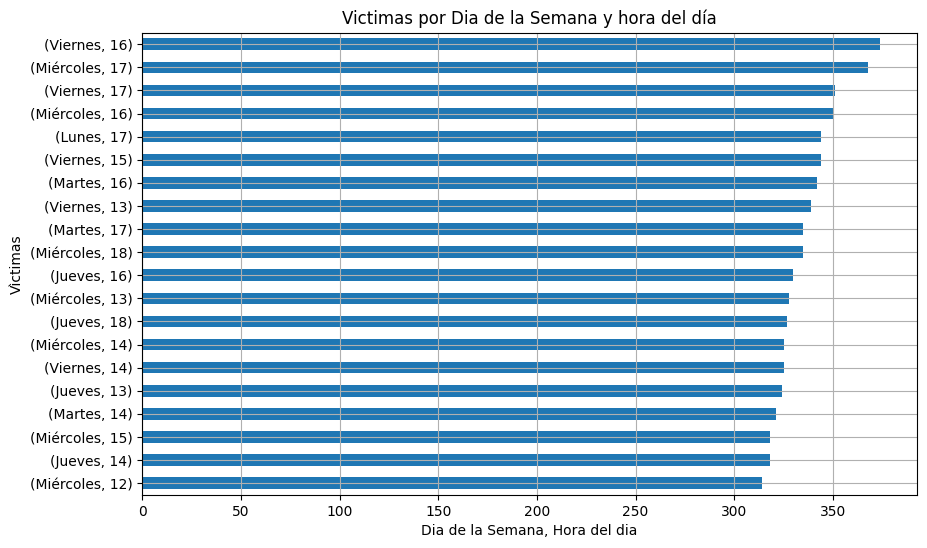

In [181]:
grouped_data = conjunto.groupby([conjunto['fecha_hora'].dt.day_name().map(day_mapping), conjunto['fecha_hora'].dt.hour])['n_victimas'].sum()
grouped_data = grouped_data.nlargest(20).sort_values(ascending=True)

# Plot the result
grouped_data.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Dia de la Semana, Hora del dia')
plt.ylabel('Vìctimas')
plt.title('Victimas por Dia de la Semana y hora del día')
plt.grid(True)
plt.show()

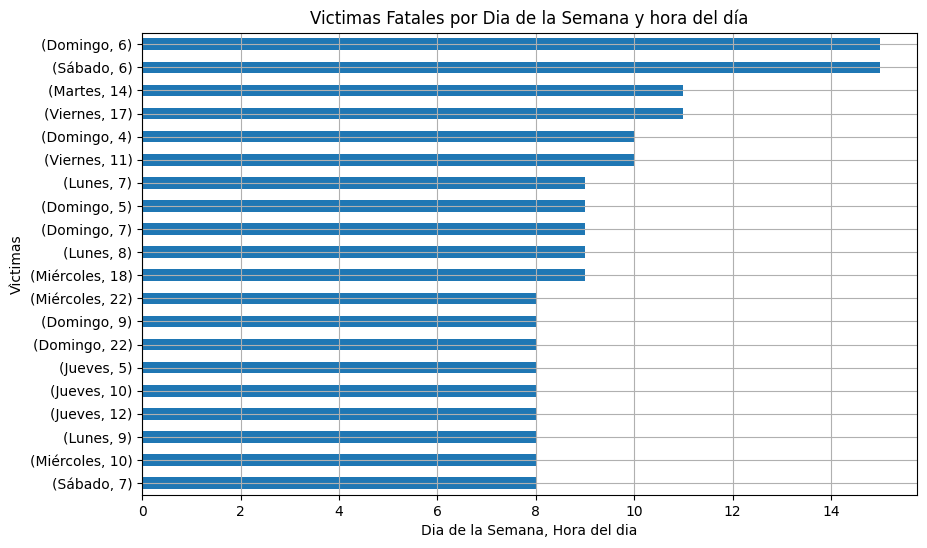

In [180]:
grouped_data = conjunto.query("gravedad == 'FATAL'").groupby([conjunto['fecha_hora'].dt.day_name().map(day_mapping), conjunto['fecha_hora'].dt.hour])['n_victimas'].sum()
grouped_data = grouped_data.nlargest(20).sort_values(ascending=True)

# Plot the result
grouped_data.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Dia de la Semana, Hora del dia')
plt.ylabel('Vìctimas')
plt.title('Victimas Fatales por Dia de la Semana y hora del día')
plt.grid(True)
plt.show()

Podemos ver que en los grupos hay 2 diferentes tipos que ocasiones preponderantes, no fatales son los dias de la semana a la tarde, y los fatales los fines de semana a la madrugada y mañana.

In [187]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = conjunto.groupby([conjunto['fecha_hora'].dt.day_name().rename('Dia_Semana'), 
                                 conjunto['fecha_hora'].dt.hour.rename('Hora_Dia')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hora_Dia', y='n_victimas', color='Dia_Semana', 
             title='Segùn la hora del dia y el dia de la semana',
             labels={'Hora_Dia': 'Hora del Día', 'n_victimas': 'Victimas Totales'},
             category_orders={'Dia_Semana': ['Lunes', 'MArtes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']})

# Show the plot
fig.show()


Gran forma de visualizar esta correlación.

In [199]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = conjunto.groupby([conjunto['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 conjunto['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Víctimas por Dia y Horas',
             labels={'Day_of_Week': 'Dia de la Semana', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


Visto desde otra perspectiva da más información.

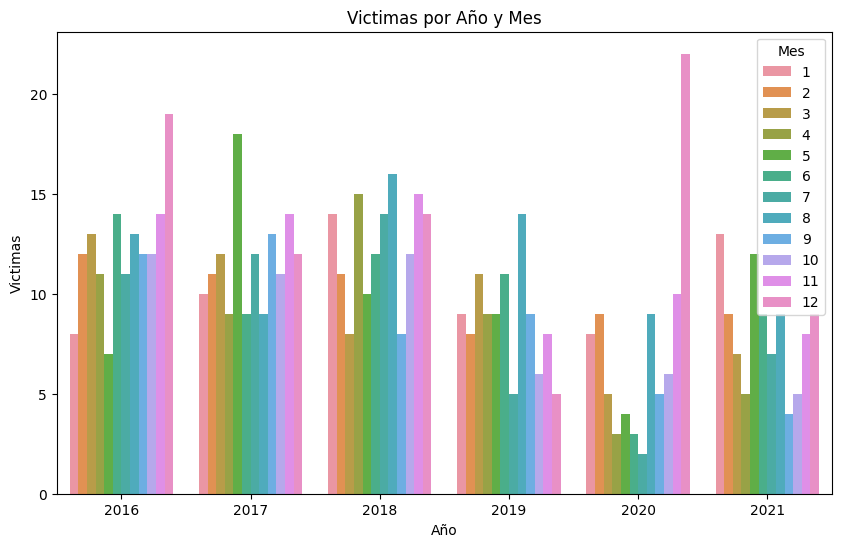

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

conjunto = conjunto.query("gravedad == 'FATAL'")

grouped_data = conjunto.groupby([conjunto['fecha_hora'].dt.year.rename('Año'), 
                                conjunto['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Victimas por Año y Mes')
plt.xlabel('Año')
plt.ylabel('Victimas')

# Show the plot
plt.show()


Ya podemos ver cómo afectó la pandemia a la baja y cómo subieron cuando se liberó el aislamiento

In [212]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = conjunto.groupby(conjunto['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total de Victimas a lo largo los años',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [ ]:
import csv

# data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [ ]:
# data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [216]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

,fecha_hora,n_victimas
0,0,103
1,1,96
2,2,97
3,3,94
4,4,95
5,5,102
6,6,97


Por día de la semana

In [ ]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

In [221]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Victimas por mes y año',
             labels={'date': 'Fecha', 'n_victimas': 'Victimas'},
             color_continuous_scale = ['lightgreen', 'yellow', 'red'],
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [225]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semestre ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
                         color_continuous_scale = ['lightgreen', 'yellow', 'red'],
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [227]:
showPiePx(data_hm.n_victimas, title='Cantidad de Victimas por Accidentes')

In [ ]:

# sns.catplot(x="tipo_de_calle", data = data_hm['tipo_de_calle', 'n_victimas'].groupby("tipo_de_calle").sum(), kind='box')

In [229]:
showPiePx(conjunto.tipo_calle)


In [231]:
import pandas as pd

autopista_counts = data_hm.query("tipo_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']
avenida_counts = data_hm.query("tipo_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']

concatenated_counts = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
data_hm.tipo_de_calle.value_counts()

In [237]:
pd.DataFrame([data_hm.query(f"tipo_calle == '{st}'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'].rename(f"{st}") for st in data_hm.tipo_calle.unique()]).T

,AVENIDA,GRAL PAZ,CALLE,AUTOPISTA
fecha_hora,,,,
0,67,11,15,13
1,58,6,25,10
2,62,9,18,9
3,62,5,18,9
4,65,6,21,5
5,59,12,23,9
6,56,16,16,11


Tabla de Frecuencias por día de la semana.